In [6]:
import os
from docx import Document
from datetime import datetime
from typing import List, Dict
from langchain_groq import ChatGroq
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from IPython.display import Image,display
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_community.tools import DuckDuckGoSearchRun
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.graph import StateGraph, END, MessagesState, START

from dotenv import load_dotenv
load_dotenv()

True

In [7]:
llm = ChatOpenAI(model='gpt-4o')
response = llm.invoke("Hi")
print(response)

content='Hello! How can I assist you today?' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 8, 'total_tokens': 17, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_a288987b44', 'id': 'chatcmpl-BkC40ntrN4Hwv5Cl9SjhgmyqGitUv', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None} id='run--a4fcdd6c-1508-4679-8e0c-4acb95517782-0' usage_metadata={'input_tokens': 8, 'output_tokens': 9, 'total_tokens': 17, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}


In [8]:
class TravelPlanner:
    def __init__(self, city: str, start_date: str, end_date: str):
        self.city = city
        self.start_date = start_date
        self.end_date = end_date
        self.trip_days = (datetime.strptime(end_date, "%Y-%m-%d") - datetime.strptime(start_date, "%Y-%m-%d")).days + 1

In [9]:
@tool
def get_attractions_and_activities(city: str) -> str:
    """Get top attractions and activities for a given city."""
    return f"Top attractions and activities in {city} include..."

In [10]:
@tool
def get_weather_forecast(city: str, start_date: str, end_date: str) -> str:
    """Get weather forecast for a given city and date range."""
    return f"Weather in {city} from {start_date} to {end_date} will be..."

In [11]:
@tool
def get_hotels_and_transport(city: str, trip_days: int) -> str:
    """Estimate hotel and transport costs for the trip duration."""
    return f"Estimated hotel and transport cost in {city} for {trip_days} days is..."

In [12]:
@tool
def generate_itinerary(city: str, start_date: str, end_date: str) -> str:
    """Generate an itinerary plan for the travel duration."""
    return f"Day-wise itinerary for {city} from {start_date} to {end_date} is..."

In [13]:
@tool
def summarize_trip(city: str, start_date: str, end_date: str) -> str:
    """One tool to summarize the entire trip, including attractions, weather, hotels, and itinerary."""
    trip_days = (datetime.strptime(end_date, "%Y-%m-%d") - datetime.strptime(start_date, "%Y-%m-%d")).days + 1
    attractions = get_attractions_and_activities(city)
    weather = get_weather_forecast(city, start_date, end_date)
    hotels = get_hotels_and_transport(city, trip_days)
    itinerary = generate_itinerary(city, start_date, end_date)

    return f"""
--- Trip Summary ---
🏙️ Attractions: {attractions}
🌦️ Weather: {weather}
🏨 Hotels: {hotels}
🗺️ Itinerary: {itinerary}
--------------------
""".strip()

In [14]:
search = DuckDuckGoSearchRun()

In [15]:
search.invoke("Latest update on Ios 26")

'CUPERTINO, CALIFORNIA Apple today previewed iOS 26, a major update that brings a beautiful new design, intelligent experiences, and improvements to the apps users rely on every day.The new design provides a more expressive and delightful experience across the system while maintaining the instant familiarity of iOS. Apple announced the latest iPhone software, iOS 26, on Monday, June 9. The first release for developers came later the same day. Just three days later, Apple released a second build of the first ... The iOS 26 beta version differs slightly from the general release. Beta testers are given a release that has recently exited its alpha phase, so problems and bugs are expected to arise. Go to Settings > Software Update > Beta Updates > Select iOS 26 Public Beta when available. General Release A general or stable release allows every compatible iPhone to run iOS 26. Apple Maps in iOS 26 (Image credit: Apple). As well as those aforementioned updates to iMessage and the Phone app, 

In [16]:
tools = [get_attractions_and_activities, get_hotels_and_transport, get_weather_forecast, generate_itinerary, summarize_trip, search]

In [17]:
llm_with_tools = llm.bind_tools(tools)

In [18]:
response = llm_with_tools.invoke("Hi")

In [19]:
response.content

'Hello! How can I assist you today?'

In [20]:
response.tool_calls

[]

In [21]:
response = llm_with_tools.invoke("I'm planning a 3-day trip to Delhi. What are the top attractions and what would be the estimated hotel and transport costs?")

In [22]:
response.content

''

In [23]:
response.tool_calls

[{'name': 'get_attractions_and_activities',
  'args': {'city': 'Delhi'},
  'id': 'call_vkSNJZGBWAvDzFZxFHEbIEFG',
  'type': 'tool_call'},
 {'name': 'get_hotels_and_transport',
  'args': {'city': 'Delhi', 'trip_days': 3},
  'id': 'call_usinCx7qnPz14c9V1pBARXIl',
  'type': 'tool_call'}]

In [24]:
SYSTEM_PROMPT = (
    "You are a helpful travel assistant tasked with planning trips using tools for attractions, weather, hotels, itinerary, search, and summarize trip. "
    "Select only the tools needed based on the user's request."
)


In [25]:
from langchain_core.messages import SystemMessage

def llm_decision_node(state):
    input_messages = [SystemMessage(content=SYSTEM_PROMPT)] + state["messages"]
    response = llm_with_tools.invoke(input_messages)  # Automatically returns AIMessage w/ tool_calls if needed
    return {"messages": [response]}

In [26]:
# def tools_condition(state):
#     last_msg = state["messages"][-1]
#     # If the last AI message has tool calls, go to tools
#     if hasattr(last_msg, "tool_calls") and last_msg.tool_calls:
#         return "tools"
#     # Else, nothing more to do — end the graph
#     return END

In [27]:
builder = StateGraph(MessagesState)

In [28]:
# Setup graph
builder.add_node("llm_decision_step", llm_decision_node)
builder.add_node("tools",ToolNode(tools)) 

builder.set_entry_point("llm_decision_step")

In [29]:
builder.add_edge(START, "llm_decision_step")
builder.add_conditional_edges("llm_decision_step",
                             tools_condition
                             )
builder.add_edge("tools", "llm_decision_step")

In [30]:
# builder.set_finish_point("llm_decision_step") 

In [31]:
react_graph = builder.compile()

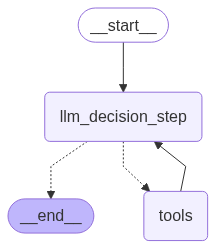

In [32]:
display(Image(react_graph.get_graph().draw_mermaid_png()))

In [33]:
result = react_graph.invoke(
    {"messages": [HumanMessage("I'm going to Delhi for 3 days. Can you estimate hotel and transport costs in INR with hotel names?")]},
    config={"recursion_limit": 100}
)
final_outputs = [msg.content for msg in result["messages"] if isinstance(msg, AIMessage)]
print(final_outputs[-1])

For a 3-day trip to Delhi, here's an estimate of hotel and transport costs:

**Hotels**:

1. **The Leela Palace** - Approx. ₹18,000 per night
2. **Taj Mahal Hotel** - Approx. ₹15,000 per night
3. **The Grand New Delhi** - Approx. ₹12,000 per night

**Transport**:
- Daily transport cost (including taxis and metro): Approx. ₹1,000 to ₹1,500 per day

**Total Estimate for 3 Days**:
- Hotel (mid-range, The Grand New Delhi): ₹36,000
- Transport: ₹3,000 to ₹4,500
- **Total estimated cost**: ₹39,000 to ₹40,500

Please note that these are approximate costs and may vary based on availability and booking choices.


In [38]:
result = react_graph.invoke(
    {"messages": [HumanMessage("I'm planning a trip to Delhi from July 1st to July 3rd. What's the weather forecast during those days?")]},
    config={"recursion_limit": 100}
)
final_outputs = [msg.content for msg in result["messages"] if isinstance(msg, AIMessage)]
print(final_outputs[-1])

The weather forecast for Delhi from July 1st to July 3rd, 2024, will be typical of summer. You can expect warm temperatures, possibly reaching the high 30s in Celsius (around the 100s in Fahrenheit), with chances of humidity. There may also be occasional rainfall due to the monsoon season starting in July. Be prepared for warm and humid weather with the possibility of rain.


In [39]:
result = react_graph.invoke(
    {"messages": [HumanMessage("I'm going to Delhi for 3 days. Can you summarize my trip in INR ")]},
    config={"recursion_limit": 100}
)
final_outputs = [msg.content for msg in result["messages"] if isinstance(msg, AIMessage)]
print(final_outputs[-1])

C:\Users\aditi_zg48xl\AppData\Local\Temp\ipykernel_16472\493622171.py:5: LangChainDeprecationWarning: The method `BaseTool.__call__` was deprecated in langchain-core 0.1.47 and will be removed in 1.0. Use :meth:`~invoke` instead.
  attractions = get_attractions_and_activities(city)


Here's a summary of your 3-day trip to Delhi in INR:

### Attractions and Activities
- **Top Attractions**: Delhi offers a mix of ancient and contemporary sights. Don't miss the Red Fort, India Gate, Qutub Minar, Lotus Temple, and Humayun’s Tomb.
- **Activities**: Enjoy a rickshaw ride in Chandni Chowk, explore the local markets, and savor the local cuisine at street food stalls.

### Weather Forecast
- **November 20-23, 2023**: Expect pleasant weather with likely sunny days and comfortable temperatures, perfect for sightseeing. There's a slight chance of evening chills, so carry a light jacket.

### Hotels and Transport Costs
- **Estimated Costs**: For 3 days, hotel accommodations and transportation might cost around 10,000 to 15,000 INR, depending on your choice of lodging and travel methods.

### Itinerary
- **Day 1**: Visit historical landmarks like the Red Fort and Humayun’s Tomb. Enjoy shopping in Connaught Place.
- **Day 2**: Explore the Qutub Minar and the Lotus Temple. Take a 